# `0 - Librerias`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

import joblib  
import os

# `1 - Carga de datos`

In [2]:
# Especificar la ruta al archivo donde se guardaron las variables
variable_folder = "../features"
variables_filename = os.path.join(variable_folder, "model_df_and_features.pkl")

# Cargar las variables
loaded_variables = joblib.load(variables_filename)

# Asignar las variables a los nombres originales
df_shopping = loaded_variables['df_shopping']
target = loaded_variables['target']
fea_num_model = loaded_variables['fea_num_model']
fea_cat_model = loaded_variables['fea_cat_model']
features_to_drop = loaded_variables['features_to_drop']
X_train = loaded_variables['X_train']
y_train = loaded_variables['y_train']
X_test = loaded_variables['X_test']
y_test = loaded_variables['y_test']


# `2 - Pipeline`

In [3]:
# Transformadores para datos categóricos y numéricos
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("exclude", "drop", features_to_drop), 
        ("num", num_transformer, fea_num_model),
        ("cat", cat_transformer, fea_cat_model)
    ], remainder='passthrough'
)

# Pipeline sin modelo
pipeline_imb_visualizacion = ImbPipeline(steps=[
    ("preprocessor", preprocessor), 
    ("smote", SMOTE(random_state=42)) 
])

### `2.1 - Ver transformaciones del data set`

In [4]:
X_pipeline, y_pipeline = pipeline_imb_visualizacion.fit_resample(X_train, y_train)

# DataFrame (solo X_train e y_train)
column_names = pipeline_imb_visualizacion.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)
df_shopping_transformado = pd.DataFrame(X_pipeline, columns=column_names)

df_shopping_transformado['Revenue'] = y_pipeline.astype(int)

df_shopping_transformado

,num__Administrative,num__ProductRelated,num__PageValues,num__ProductRelated_Duration,num__BounceRates,num__ExitRates,cat__Month_Dec,cat__Month_Feb,cat__Month_Jul,cat__Month_June,...,cat__Month_Oct,cat__Month_Sep,cat__SpecialDay_0.2,cat__SpecialDay_0.4,cat__SpecialDay_0.6,cat__SpecialDay_0.8,cat__SpecialDay_1.0,cat__VisitorType_Other,cat__VisitorType_Returning_Visitor,Revenue
0,1.450438,0.593733,1.927643,0.592626,-0.285981,-0.826352,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,-0.991485,-1.130270,-0.530566,-0.697177,1.488583,1.562432,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,-0.991485,-1.130270,-0.530566,-1.220568,-0.797632,0.716121,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.562971,-0.003214,1.955261,0.509738,0.297545,0.321795,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,-0.991485,0.540581,1.980610,0.241800,-0.797632,-1.732567,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16671,-0.991485,-1.162172,-0.530566,-1.020514,-0.797632,1.486310,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
16672,1.179061,-0.108096,-0.530566,0.949913,0.374801,0.320489,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
16673,1.374622,1.971934,1.944968,1.605791,-0.790427,-1.221718,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
16674,-0.991485,0.105189,-0.530566,-0.100993,0.984728,0.623353,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [5]:
# Se comprueba si SMOTE ha funcionado
y_pipeline.value_counts()

Revenue
False    8338
True     8338
Name: count, dtype: int64

### `2.2 - Guardado datos transformados`

>`X_train/y_train --> Transformación + SMOTE`    
`X_test_trans --> Transformación`    
`y_test`

In [6]:
output_folder = "../data/processed"
output_file = os.path.join(output_folder, "shopping_transformado_X_train_y_train_only.csv")

df_shopping_transformado.to_csv(output_file, index=False)

In [7]:
preprocessor = pipeline_imb_visualizacion.named_steps['preprocessor']

# Aplicar sólo el preprocesador al conjunto de prueba
X_test_transformed = preprocessor.transform(X_test)

In [8]:
# Especificar la carpeta de destino
variable_folder = "../data/processed"
os.makedirs(variable_folder, exist_ok=True)

# Ruta del archivo donde se guardarán las variables
variables_filename = os.path.join(variable_folder, "set_datos_transformados_SMOTE.pkl")

# Guardar las variables en un solo archivo
variables_to_save = {
                    'shopping_trans_X_y': df_shopping_transformado,
                    'X_test_trans': X_test_transformed,
                    'y_test': y_test
                    }
joblib.dump(variables_to_save, variables_filename)

print(f"Variables guardadas como: {variables_filename}")

Variables guardadas como: ../data/processed\set_datos_transformados_SMOTE.pkl


# `3 - Modelado`

## `3.1 - Modelos`

In [9]:
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='aucpr', random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, thread_count=-1),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),  
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'NaiveBayes': GaussianNB(),  
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42, n_iter_no_change=10),  
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

## `3.2 - Aplicación Pipeline + Selección best model`

In [10]:
balanced_accuracy_scores = {}

for model_name, model in models.items():
    pipeline_imb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),                  
    ("smote", SMOTE(random_state=42)), 
    ('classifier', model)
    ])
    
    pipeline_imb.fit(X_train, y_train)

    models_pkl_folder = "../model/Base_model/Scoring_balanced_accuracy"
    model_filename = os.path.join(models_pkl_folder, f"{model_name}_base_model.pkl")
    joblib.dump(pipeline_imb, model_filename) 
    print(f"Modelo {model_name} guardado como {model_filename}\n")
    
    cv_scores = cross_val_score(pipeline_imb, X_train, y_train, cv=5, scoring="balanced_accuracy", error_score="raise")
    mean_score = np.mean(cv_scores)
    balanced_accuracy_scores[model_name] = mean_score
    print(f"Modelo: {model_name}, Balanced Accuracy: {mean_score:.4f}")


Modelo RandomForest guardado como ../model/Base_model/Scoring_balanced_accuracy\RandomForest_base_model.pkl

Modelo: RandomForest, Balanced Accuracy: 0.8280
Modelo XGBoost guardado como ../model/Base_model/Scoring_balanced_accuracy\XGBoost_base_model.pkl

Modelo: XGBoost, Balanced Accuracy: 0.8145
Modelo LightGBM guardado como ../model/Base_model/Scoring_balanced_accuracy\LightGBM_base_model.pkl

Modelo: LightGBM, Balanced Accuracy: 0.8252
Modelo CatBoost guardado como ../model/Base_model/Scoring_balanced_accuracy\CatBoost_base_model.pkl

Modelo: CatBoost, Balanced Accuracy: 0.8231
Modelo LogisticRegression guardado como ../model/Base_model/Scoring_balanced_accuracy\LogisticRegression_base_model.pkl

Modelo: LogisticRegression, Balanced Accuracy: 0.8456
Modelo SVM guardado como ../model/Base_model/Scoring_balanced_accuracy\SVM_base_model.pkl

Modelo: SVM, Balanced Accuracy: 0.8606
Modelo KNN guardado como ../model/Base_model/Scoring_balanced_accuracy\KNN_base_model.pkl

Modelo: KNN, Ba

In [11]:
df_recall_scores = pd.DataFrame(list(balanced_accuracy_scores.items()), columns=["Modelo", "Balanced Accuracy"])
df_recall_scores = df_recall_scores.sort_values(by="Balanced Accuracy", ascending=False).reset_index(drop=True)
df_recall_scores

,Modelo,Balanced Accuracy
0,SVM,0.860600
1,GradientBoosting,0.851546
2,LogisticRegression,0.845554
3,AdaBoost,0.839757
4,RandomForest,0.828036
5,LightGBM,0.825159
6,CatBoost,0.823112
7,KNN,0.822724
8,XGBoost,0.814518
9,DecisionTree,0.765163


In [12]:
best_models = list(df_recall_scores[:5]["Modelo"])
best_models

['SVM', 'GradientBoosting', 'LogisticRegression', 'AdaBoost', 'RandomForest']

In [13]:
from sklearn import set_config

set_config(display="diagram")

pipeline_imb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('exclude', 'drop',
                                                  ['OperatingSystems', 'Region',
                                                   'Weekend',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'Browser', 'TrafficType']),
                                                 ('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['Administrative',
                                                   'ProductRelated',
                                                   'PageValues',
                                                   'ProductRelated_Duration',
                                                   'BounceRates',
                                                   'ExitRates']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Month', 'SpecialDay',
                                                   'VisitorType'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', AdaBoostClassifier(random_state=42))])

## `3.3 - Grid Search sobre los mejores modelos`

- Incluimos XGBoost aunque no ha sido uno de los mejores, pues queremos seguir haciendo la comparativa de la evolucion de su scoring conforme se van apliacando técnicas de ML.
- Hay que recordar que XGBoost fue el modelo elegido como Baseline y sobre el tenemos diferentes resultados de scorings segun el se le van aplicando transformaciones.


In [14]:
param_grids = {
    'XGBoost': {
    'classifier__n_estimators': [50, 100, 200],  
    'classifier__learning_rate': [0.01, 0.1, 0.2], 
    'classifier__max_depth': [3, 5, 7],  
    'classifier__scale_pos_weight': [1, 5, 10]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10], 
        'classifier__kernel': ['linear', 'rbf'], 
        'classifier__gamma': ['scale', 'auto'] 
    },
    'GradientBoosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [-1, 3, 5, 7],
        'classifier__num_leaves': [20, 31, 50]
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2', 'none'],
        'classifier__solver': ['lbfgs', 'saga']
    },
    'AdaBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0]
    }
}


In [15]:
models = {
    'XGBoost': XGBClassifier(eval_metric='aucpr', random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),  
    'GradientBoosting': GradientBoostingClassifier(random_state=42, n_iter_no_change=10),  
    'AdaBoost': AdaBoostClassifier(random_state=42)  
}

grid_search_results = []

# GridSearch para cada modelo
for model_name, model in models.items():
    pipeline_imb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),                  
    ("smote", SMOTE(random_state=42)), 
    ('classifier', model)
    ])
    

    grid_search = GridSearchCV(
        pipeline_imb, 
        param_grid=param_grids[model_name],
        cv=5, 
        scoring="balanced_accuracy", 
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    grid_search_results.append((model_name, best_model, best_score))
    print(f"Modelo: {model_name}, Mejor Balanced Accuracy en validación: {best_score:.4f}")

    models_pkl_folder = "../model/Best_params_model/Scoring_balanced_accuracy"
    model_filename = os.path.join(models_pkl_folder, f"{model_name}_best_model.pkl")
    joblib.dump(best_model, model_filename) 
    print(f"Modelo {model_name} guardado como {model_filename}\n")

Modelo: XGBoost, Mejor Balanced Accuracy en validación: 0.8566
Modelo XGBoost guardado como ../model/Best_params_model/Scoring_balanced_accuracy\XGBoost_best_model.pkl

Modelo: LightGBM, Mejor Balanced Accuracy en validación: 0.8561
Modelo LightGBM guardado como ../model/Best_params_model/Scoring_balanced_accuracy\LightGBM_best_model.pkl

Modelo: LogisticRegression, Mejor Balanced Accuracy en validación: 0.8489
Modelo LogisticRegression guardado como ../model/Best_params_model/Scoring_balanced_accuracy\LogisticRegression_best_model.pkl

Modelo: SVM, Mejor Balanced Accuracy en validación: 0.8612
Modelo SVM guardado como ../model/Best_params_model/Scoring_balanced_accuracy\SVM_best_model.pkl

Modelo: GradientBoosting, Mejor Balanced Accuracy en validación: 0.8571
Modelo GradientBoosting guardado como ../model/Best_params_model/Scoring_balanced_accuracy\GradientBoosting_best_model.pkl

Modelo: AdaBoost, Mejor Balanced Accuracy en validación: 0.8494
Modelo AdaBoost guardado como ../model/B

## `3.4 - Scoring de los mejores modelos`

Resultados para el modelo: XGBoost_best_model
Balanced Accuracy en el conjunto de prueba: 0.8430

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2084
        True       0.50      0.84      0.62       382

    accuracy                           0.84      2466
   macro avg       0.73      0.84      0.76      2466
weighted avg       0.89      0.84      0.86      2466

------------------------------------------------------------


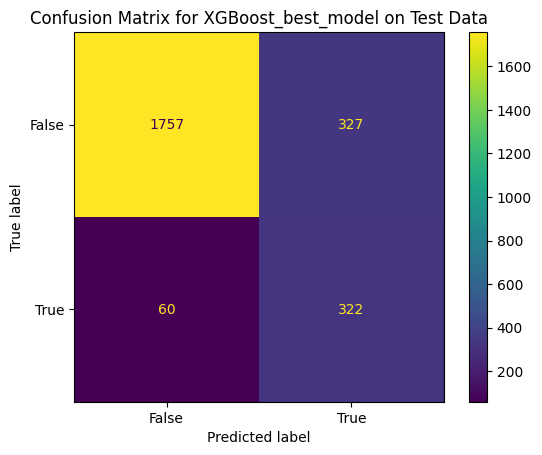

Resultados para el modelo: LightGBM_best_model
Balanced Accuracy en el conjunto de prueba: 0.8489

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.86      0.91      2084
        True       0.52      0.84      0.64       382

    accuracy                           0.85      2466
   macro avg       0.74      0.85      0.78      2466
weighted avg       0.90      0.85      0.87      2466

------------------------------------------------------------


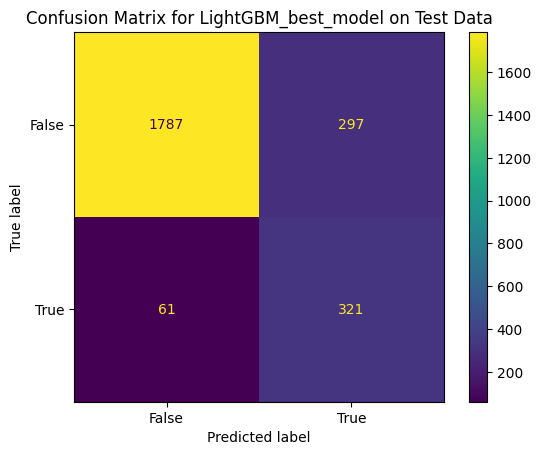

Resultados para el modelo: LogisticRegression_best_model
Balanced Accuracy en el conjunto de prueba: 0.8281

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.96      0.87      0.91      2084
        True       0.53      0.79      0.63       382

    accuracy                           0.86      2466
   macro avg       0.74      0.83      0.77      2466
weighted avg       0.89      0.86      0.87      2466

------------------------------------------------------------


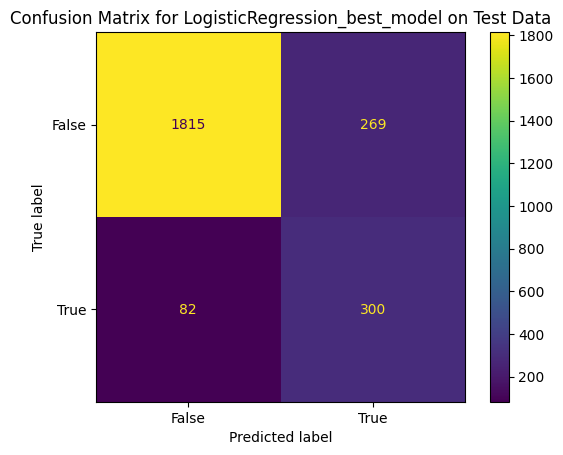

Resultados para el modelo: SVM_best_model
Balanced Accuracy en el conjunto de prueba: 0.8582

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.86      0.91      2084
        True       0.52      0.86      0.65       382

    accuracy                           0.86      2466
   macro avg       0.75      0.86      0.78      2466
weighted avg       0.90      0.86      0.87      2466

------------------------------------------------------------


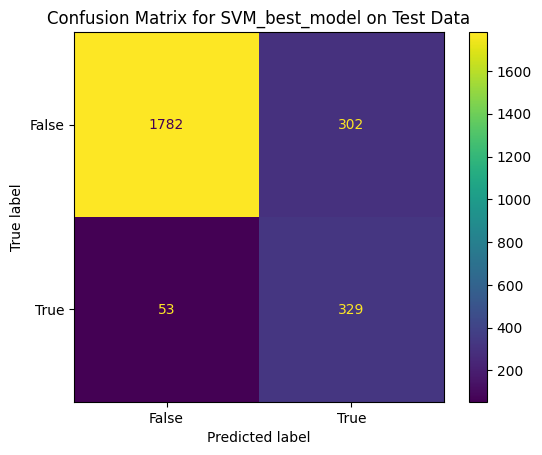

Resultados para el modelo: GradientBoosting_best_model
Balanced Accuracy en el conjunto de prueba: 0.8435

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2084
        True       0.50      0.84      0.63       382

    accuracy                           0.84      2466
   macro avg       0.73      0.84      0.76      2466
weighted avg       0.89      0.84      0.86      2466

------------------------------------------------------------


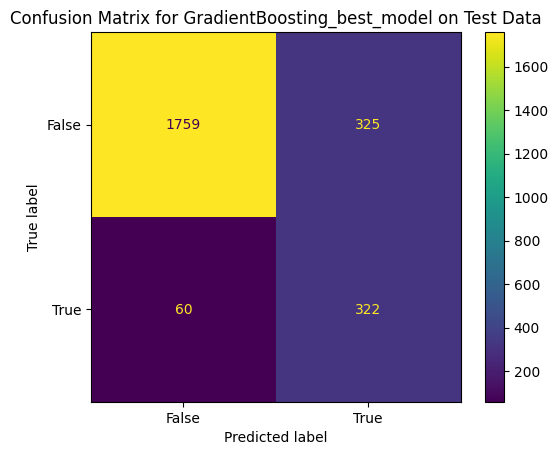

Resultados para el modelo: AdaBoost_best_model
Balanced Accuracy en el conjunto de prueba: 0.8302

Reporte de Clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      2084
        True       0.56      0.77      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466

------------------------------------------------------------


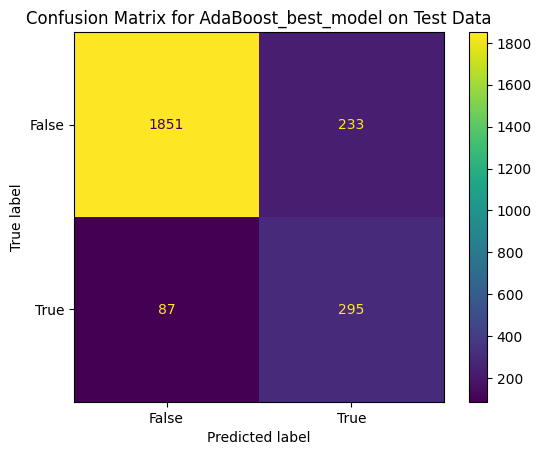

In [16]:
# Modelos
model_names = [f"{model_name}_best_model" for model_name in models.keys()]

# Best params de los modelos
base_path = "../model/Best_params_model/Scoring_balanced_accuracy/"


for model_name in model_names:
    
    model_path = f"{base_path}{model_name}.pkl"
    modelo_entrenado = joblib.load(model_path)
    
    y_pred = modelo_entrenado.predict(X_test)
    
    # Balanced Accuracy y Classification Report
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    
    print(f"Resultados para el modelo: {model_name}")
    print(f"Balanced Accuracy en el conjunto de prueba: {balanced_acc:.4f}")
    print("\nReporte de Clasificación en el conjunto de prueba:")
    print(classification_rep)
    print("-" * 60)
    
    # Matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix for {model_name} on Test Data")
    plt.show()